In [79]:
import torch
import torch.nn as nn
from typing import List

class Generator(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Feature extractor network."""
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

class Critic(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int]):
        """Domain critic network."""
        super().__init__()
        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
            ])
            prev_dim = hidden_dim

        self.net = nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

In [80]:
from typing import Optional
import numpy as np
from tqdm.notebook import trange
from torch.utils.data import DataLoader

class WDGRL():
    def __init__(self, input_dim: int=2, generator_hidden_dims: List[int]=[32, 16, 8, 4, 2], critic_hidden_dims: List[int]=[32, 16, 8, 4, 2],
                 gamma: float = 0.1, _lr_generator: float = 1e-2, _lr_critic: float = 1e-2, 
                 device: str = 'cuda' if torch.cuda.is_available() else 'cpu'):

        self.gamma = gamma
        self.device = device
        self.generator = Generator(input_dim, generator_hidden_dims).to(self.device)
        self.critic = Critic(generator_hidden_dims[-1], critic_hidden_dims).to(self.device)
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=_lr_generator)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=_lr_critic)
    
    # def compute_gradient_penalty(self, source_data: torch.Tensor, target_data: torch.Tensor) -> torch.Tensor:
    #     """Compute gradient penalty."""
    #     if source_data.size(0) > target_data.size(0):
    #         ms = source_data.size(0)
    #         mt = target_data.size(0)
    #         gradient_penalty = 0
    #         for _ in range(0, ms, mt):
    #             source_chunk = source_data[_:_+mt]
    #             target_chunk = target_data
    #             alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
    #             interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
    #             # Domain critic outputs
    #             dc_output = self.critic(interpolates)
                
    #             # Compute gradients
    #             gradients = torch.autograd.grad(
    #                 outputs=dc_output,
    #                 inputs=interpolates,
    #                 grad_outputs=torch.ones_like(dc_output).to(self.device),
    #                 create_graph=True,
    #                 retain_graph=True,
    #                 only_inputs=True,
    #             )
    #             gradients = gradients[0]
    #             gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    #         if ms % mt != 0:
    #             source_chunk = source_data[ms-mt:]
    #             perm = torch.randperm(mt)
    #             idx = perm[:ms % mt]
    #             target_chunk = target_data[idx]
    #             alpha = torch.rand(target_chunk.size(0), 1).to(self.device)
    #             interpolates = (alpha * source_chunk + ((1 - alpha) * target_chunk)).requires_grad_(True)
                
    #             # Domain critic outputs
    #             dc_output = self.critic(interpolates)
                
    #             # Compute gradients
    #             gradients = torch.autograd.grad(
    #                 outputs=dc_output,
    #                 inputs=interpolates,
    #                 grad_outputs=torch.ones_like(dc_output).to(self.device),
    #                 create_graph=True,
    #                 retain_graph=True,
    #                 only_inputs=True,
    #             )
    #             gradients = gradients[0]
    #             gradient_penalty += ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    #         return gradient_penalty / ((ms // mt) + (ms % mt != 0)) 
        
    #     # For balanced batch
    #     alpha = torch.rand(source_data.size(0), 1).to(self.device)
    #     interpolates = (alpha * source_data + ((1 - alpha) * target_data)).requires_grad_(True)
        
    #     # Domain critic outputs
    #     dc_output = self.critic(interpolates)
        
    #     # Compute gradients
    #     gradients = torch.autograd.grad(
    #         outputs=dc_output,
    #         inputs=interpolates,
    #         grad_outputs=torch.ones_like(dc_output).to(self.device),
    #         create_graph=True,
    #         retain_graph=True,
    #         only_inputs=True,
    #     )[0]

    #     # Compute gradient penalty
    #     gradients = gradients.view(gradients.size(0), -1)
    #     return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    def compute_gradient_penalty(self, source_data: torch.Tensor, target_data: torch.Tensor) -> torch.Tensor:
        alpha = torch.rand(source_data.size(0), 1).to(self.device)
        differences = target_data - source_data 
        interpolates = source_data + (alpha * differences)
        interpolates = torch.stack([interpolates, source_data, target_data]).requires_grad_()

        preds = self.critic(interpolates)
        gradients = torch.autograd.grad(preds, interpolates,
                     grad_outputs=torch.ones_like(preds),
                     retain_graph=True, create_graph=True)[0]
        gradient_norm = gradients.norm(2, dim=1)
        gradient_penalty = ((gradient_norm - 1)**2).mean()
        return gradient_penalty


    def train(self, source_loader: DataLoader, target_loader: DataLoader, num_epochs: int = 100, dc_iter: int = 100) -> List[float]:
        self.generator.train()
        self.critic.train()
        losses = []
        source_critic_scores = []
        target_critic_scores = []
        for epoch in trange(num_epochs, desc='Epoch'):
            loss = 0
            total_loss = 0
            for (source_data, _), (target_data, _) in zip(source_loader, target_loader):
                source_data, target_data = source_data.to(self.device), target_data.to(self.device)

                # Train domain critic
                for _ in range(dc_iter):
                    self.critic_optimizer.zero_grad()
                    
                    with torch.no_grad():
                        source_features = self.generator(source_data).view(source_data.size(0), -1)
                        target_features = self.generator(target_data).view(target_data.size(0), -1)
                    
                    # Compute empirical Wasserstein distance
                    dc_source = self.critic(source_features)
                    dc_target = self.critic(target_features)
                    wasserstein_distance = (dc_source.mean() - dc_target.mean())

                    # Gradient penalty
                    gradient_penalty = self.compute_gradient_penalty(source_features, target_features)

                    # Domain critic loss
                    dc_loss = - wasserstein_distance + self.gamma * gradient_penalty
                    print(f'- iteration #{_} / {dc_iter} | source critic: {dc_source.mean().item()} | target critic: {dc_target.mean().item()} | wasserstein distance: {wasserstein_distance.item()} | gradient penalty: {gradient_penalty.item()}')
                    dc_loss.backward()
                    self.critic_optimizer.step()
                    with torch.no_grad():
                        total_loss += wasserstein_distance.item()
                print('-------------------------------')
                # Train feature extractor
                self.generator_optimizer.zero_grad()
                source_features = self.generator(source_data)
                target_features = self.generator(target_data)
                dc_source = self.critic(source_features)
                dc_target = self.critic(target_features)
                wasserstein_distance = (dc_source.mean() - dc_target.mean())
                wasserstein_distance.backward()
                self.generator_optimizer.step()
                with torch.no_grad():
                    loss += wasserstein_distance.item()
                
                    
            source_critic_scores.append(self.criticize(source_loader.dataset.tensors[0].to(self.device)))
            target_critic_scores.append(self.criticize(target_loader.dataset.tensors[0].to(self.device)))
            losses.append(loss/len(source_loader))
            print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {loss/len(source_loader)}')
            print('--------------------------------')
        return losses, source_critic_scores, target_critic_scores
    
    @torch.no_grad()
    def extract_feature(self, x: torch.Tensor) -> torch.Tensor:
        self.generator.eval()
        return self.generator(x)
    
    @torch.no_grad()
    def criticize(self, x: torch.Tensor) -> float:
        self.generator.eval()
        self.critic.eval()
        return self.critic(self.generator(x)).mean().item()

In [81]:
import numpy as np
# np.random.seed(42)
# torch.manual_seed(42)
def gen_data(mu: float, delta: List[int], n: int, d: int):
    mu = np.full((n, d), mu, dtype=np.float64)
    noise = np.random.normal(loc = 0, scale = 1, size=(n, d))
    X = mu + noise
    labels = np.zeros(n)
    # 5% of the data is abnormal.
    # Anomalies are generated by randomly adding deltas to the data.
    n_anomalies = int(n * 0.05)
    idx = np.random.choice(n, n_anomalies, replace=False)
    if 0 in delta: 
        delta.pop(delta.index(0))
    split_points = sorted(np.random.choice(range(1, len(idx)), len(delta) - 1, replace=False))
    segments = np.split(idx, split_points)
    for i, segment in enumerate(segments):
        X[segment] = X[segment] + delta[i]
    labels[idx] = 1
    return X, labels

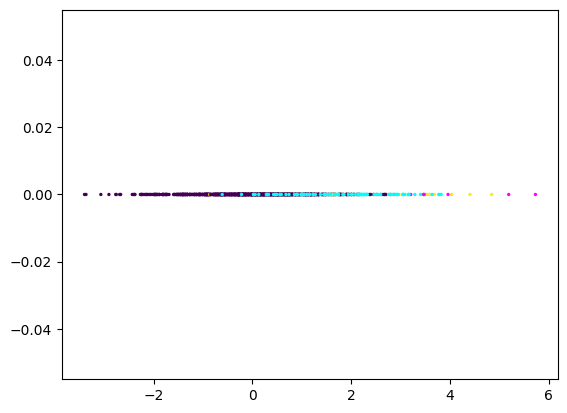

In [82]:
import matplotlib.pyplot as plt

"""Create synthetic dataset and dataloaders for domain adaptation."""
# Create datasets
ns, nt, d = 1000, 100, 1

xs, ys = gen_data(0, [0, 1, 2, 3, 4], ns, d)
xt, yt = gen_data(2, [0, 1, 2, 3, 4], nt, d)

plt.scatter(xs[:, 0], np.zeros_like(xs[:, 0]), c=ys, cmap='viridis', s=2)
plt.scatter(xt[:, 0], np.zeros_like(xt[:, 0]), c=yt, cmap='cool', s=2)
plt.show()

In [83]:
def common_divisors(N_A, N_B):
    gcd = np.gcd(N_A, N_B)  # Step 1: Compute GCD
    return [d for d in range(1, gcd + 1) if gcd % d == 0]

common_divisors(ns, nt)
cd = [d for d in reversed(common_divisors(ns, nt)) if nt//d >= 5]
cd = cd[0]
cd

20

In [84]:
# Convert to PyTorch tensors
xs = torch.FloatTensor(xs)
ys = torch.LongTensor(ys)
xt = torch.FloatTensor(xt)
yt = torch.LongTensor(yt)

from torch.utils.data import DataLoader, TensorDataset 
source_dataset = TensorDataset(xs, ys)
target_dataset = TensorDataset(xt, yt)
source_loader = DataLoader(source_dataset, batch_size=cd, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=cd, shuffle=True)

In [85]:
generator_hidden_dims = [10, 10, 10]
critic_hidden_dims = [4, 2, 1]
model = WDGRL(input_dim=d, generator_hidden_dims=generator_hidden_dims, critic_hidden_dims=critic_hidden_dims)
num_epochs = 5
losses, source_critic_scores, target_critic_scores = model.train(source_loader, target_loader, num_epochs=num_epochs, dc_iter=100)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

- iteration #0 / 100 | source critic: 0.38818225264549255 | target critic: 0.38758584856987 | wasserstein distance: 0.0005964040756225586 | gradient penalty: 0.9817102551460266
- iteration #1 / 100 | source critic: 0.3834030330181122 | target critic: 0.3824044167995453 | wasserstein distance: 0.0009986162185668945 | gradient penalty: 0.9746381640434265
- iteration #2 / 100 | source critic: 0.3785693645477295 | target critic: 0.37707290053367615 | wasserstein distance: 0.0014964640140533447 | gradient penalty: 0.9665807485580444
- iteration #3 / 100 | source critic: 0.37367573380470276 | target critic: 0.3715951144695282 | wasserstein distance: 0.0020806193351745605 | gradient penalty: 0.9574245810508728
- iteration #4 / 100 | source critic: 0.36871811747550964 | target critic: 0.3660072982311249 | wasserstein distance: 0.0027108192443847656 | gradient penalty: 0.9471535086631775
- iteration #5 / 100 | source critic: 0.36369314789772034 | target critic: 0.360260009765625 | wasserstein d

In [86]:
xs_hat = model.extract_feature(xs.cuda())
xt_hat = model.extract_feature(xt.cuda())
xs_hat = xs_hat.cpu().numpy()
xt_hat = xt_hat.cpu().numpy()
print(xs_hat)
print(xt_hat)

[[0.         0.14710993 0.         ... 0.         0.24903262 0.10346248]
 [0.         0.14958477 0.         ... 0.         0.2933225  0.16145408]
 [0.         0.1526033  0.         ... 0.         0.24301264 0.08621869]
 ...
 [0.         0.1745194  0.         ... 0.         0.320602   0.20285568]
 [0.         0.15016523 0.         ... 0.         0.24568444 0.09387188]
 [0.01636434 0.1802051  0.         ... 0.00746244 0.22342819 0.01413006]]
[[4.97877747e-02 1.95684284e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.20758691e-02 0.00000000e+00 4.15616035e-02
  2.20043868e-01 0.00000000e+00]
 [0.00000000e+00 1.45182967e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.57905126e-01 1.18995756e-01]
 [0.00000000e+00 1.57179922e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.35793173e-01 6.88521340e-02]
 [0.00000000e+00 1.56231076e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.0000

In [87]:
print(np.sum(xs_hat, axis=1))
print(np.sum(xt_hat, axis=1))

[0.49960503 0.60436136 0.48183462 0.7232268  0.54760545 0.51431555
 0.50349426 0.45960677 0.7538216  0.77491033 0.73139364 0.5095919
 0.4916099  0.48962036 0.5268929  0.48156488 1.245655   0.42925355
 0.42733485 0.5802825  0.58299524 0.47670448 0.466865   0.55201983
 1.2719579  0.54232514 0.838995   0.57682526 0.9608765  0.46084112
 0.5153315  0.5819405  0.53953975 0.50521815 0.54838324 0.54676044
 0.72847664 0.43220747 1.2351851  0.68896914 0.56539416 0.5699985
 0.75964785 0.4794246  0.5286231  0.7235817  0.94070613 0.86230385
 0.55795324 0.5002952  0.79410315 0.8928366  0.46081597 0.85135764
 0.7651993  0.4483592  0.58351594 0.4397055  0.62857383 0.50744224
 0.59233546 0.5717865  0.5551836  0.62831813 0.55101603 0.65447485
 0.5507793  1.0188271  1.3488514  0.49463776 0.5466517  0.55132926
 0.43408087 0.65966356 0.50104797 0.48526475 0.6335483  0.7913312
 0.7485581  0.4917205  0.4400829  0.49357927 0.8675078  0.5451822
 0.5015468  0.5542037  1.3254106  0.55147165 0.43334585 0.5230121


In [88]:
print(max(np.sum(xs_hat, axis=1)))
print(max(np.sum(xt_hat, axis=1)))

2.0618358
1.4938371


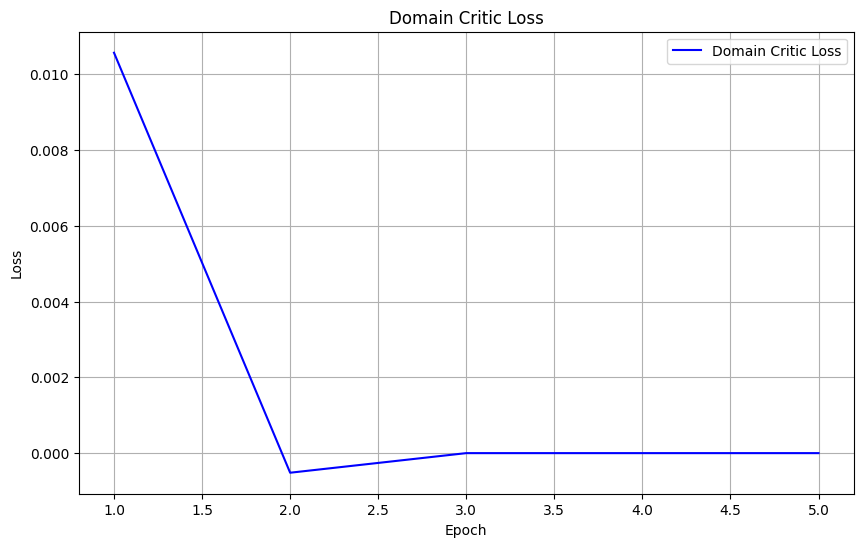

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), losses, 'b-', label='Domain Critic Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Domain Critic Loss')
plt.legend()
plt.grid(True)
plt.show()

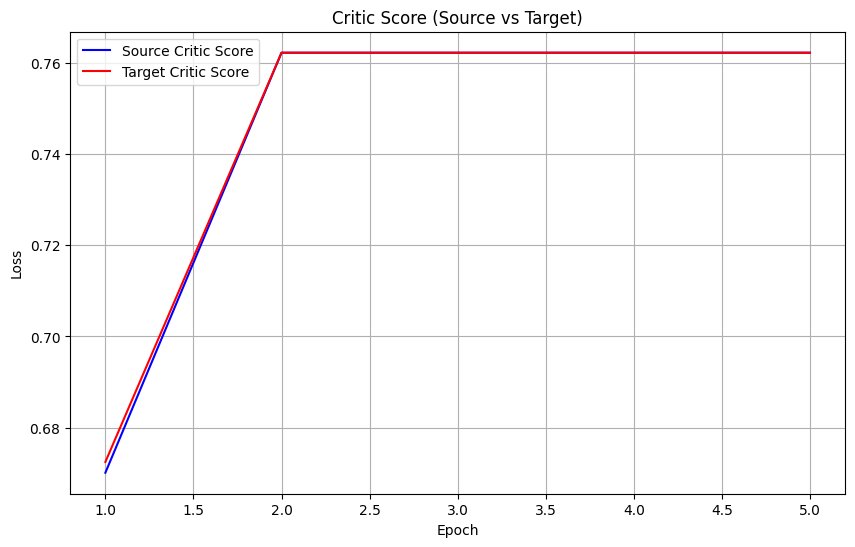

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), source_critic_scores, 'b-', label='Source Critic Score')
plt.plot(range(1, num_epochs+1), target_critic_scores, 'r-', label='Target Critic Score')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Critic Score (Source vs Target)')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
# Define a dictionary with all the necessary components
checkpoint = {
    'generator_state_dict': model.generator.state_dict(),
    'critic_state_dict': model.critic.state_dict(),
    'device': model.device,
}
index = None

with open("models.txt", "r") as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        words = line[:-1].split("/")
        if words[1] == str(generator_hidden_dims) and words[2] == str(critic_hidden_dims):
            index = i
            break
if index is None:
    with open("models.txt", "r") as f:
        index = len(f.readlines())
    with open("models.txt", "a") as f:
        f.write(f"{index}/{generator_hidden_dims}/{critic_hidden_dims}\n")
# Save the checkpoint
torch.save(checkpoint, f"wdgrl_{index}.pth")
print("Model saved successfully!")

Model saved successfully!
